In [9]:
# cfgs
import numpy as np
import os

cfgs=[]
for replica in ['a','b']:
    path=f'/capstor/scratch/cscs/fpittler/configs/a09m130W/correct/{replica}/'
    t=[f'{replica}{cfg[-4:]}' for cfg in os.listdir(path) if cfg.startswith('conf.')]
    cfgs+=t
cfgs.sort()

path='data_aux/cfgs_all'
with open(path,'w') as f:
    f.write('\n'.join(cfgs))

len(cfgs)

339

In [2]:
# create srcs
import numpy as np
import h5py,random

dims=[64,64,64,96]; Nsrc=10000

path='data_aux/cfgs_run'
with open(path,'r') as f:
    cfgs=f.read().splitlines()
    
srcs={}

path='/capstor/store/cscs/userlab/lp139/lyan/code/projectData/03_NpiScatteringWilson/MILC_a09m130W/data_aux/srcs.h5'
with h5py.File(path) as f:
    for cfg in f.keys():
        srcs[cfg]=f[cfg][:]
        
def remove_duplicates(seq):
    seen = set()
    result = []
    for item in seq:
        if item not in seen:
            seen.add(item)
            result.append(item)
    return result

for cfg in cfgs:
    print(cfg,end='             \r')
    if cfg in srcs:
        t0=[tuple([int(e) for e in ele]) for ele in srcs[cfg]]
    else:
        t0=[]

    t=t0
    while len(t)<Nsrc:
        # t=set(t0+[tuple([random.choice(range(dim)) for dim in dims]) for i in range(Nsrc*2)])
        
        t=t0+[tuple([random.choice(range(dim)) for dim in dims]) for i in range(Nsrc*2)]
        t=remove_duplicates(t)
        
        t=[list(ele) for ele in list(t)]  
        
    srcs[cfg]=t[:Nsrc]
    # print(len(srcs[cfg]),len(t[:Nsrc]))
    # break

with h5py.File(path,'w') as f:
    for cfg in srcs.keys():
        f.create_dataset(cfg,data=srcs[cfg])

In [4]:
# create srcs.${cfg}
import numpy as np
import h5py,os

i_start=0; i_end=100
print(f'Nsrc={i_end-i_start}: {i_start}-{i_end-1}')

path='data_aux/cfgs_run'
with open(path,'r') as f:
    cfgs=f.read().splitlines()
    
srcs={}
path='data_aux/srcs.h5'
with h5py.File(path) as f:
    for cfg in f.keys():
        srcs[cfg]=f[cfg][:]

pathBase='/capstor/store/cscs/userlab/lp139/lyan/code/scratch/run/03_NpiScatteringWilson/MILC_a09m130W/run/'
for cfg in cfgs:
    # if cfg!='a0050':
    #     continue
    path=f'{pathBase}{cfg}/'
    os.makedirs(path,exist_ok=True)
    with open(f'{path}src.{cfg}','w') as f:
        t=srcs[cfg][i_start:i_end]
        t='\n'.join([' '.join([str(e) for e in ele]) for ele in t])
        f.write(t)
    # break

Nsrc=100: 0-99


In [ ]:
# check flagFinish
import numpy as np
import h5py,os

path='data_aux/cfgs_run'
with open(path,'r') as f:
    cfgs=f.read().splitlines()
    
for cfg in cfgs:
    path=f'/capstor/store/cscs/userlab/lp139/lyan/code/scratch/run/03_NpiScatteringWilson/MILC_a09m130W/run/{cfg}/'
    path_new=f'/capstor/store/cscs/userlab/lp139/lyan/code/scratch/run/03_NpiScatteringWilson/MILC_a09m130W/run_fail/{cfg}/'
    files=os.listdir(path)
    if 'flagFinish' not in files:
        print(cfg)
        # for file in files:
        #     if file.startswith('run') or file.startswith('src') or file.startswith('global'):
        #         continue
        #     os.makedirs(path_new,exist_ok=True)
        #     os.rename(f'{path}{file}',f'{path_new}{file}')

b0708
b0714
b0726
b0738
b1110
b1164
b1170
b1218
b1224
b1236
b1260
b1284
b1290
b1326
b1344


# test

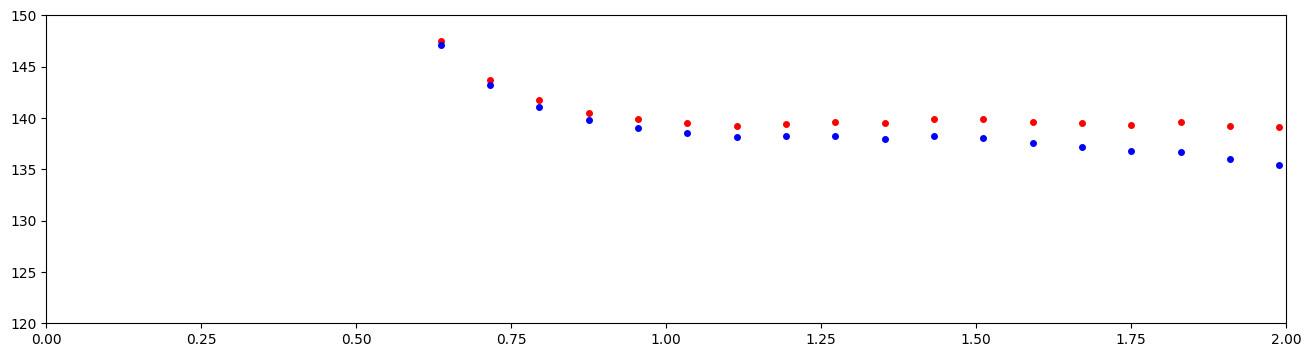

In [40]:
# P
import numpy as np
import h5py, warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import leastsq, curve_fit, fsolve
mpl.rcParams['lines.markersize'] = 4

totalT=128

lat_a=0.07957
hbarc = 1/197.3
lat_aInv=1/(lat_a*hbarc)

def fsolve2(func,x0):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res=fsolve(func, x0)[0]
    return res if res!=x0 else np.NaN
tau=1
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t

def c2pt2meff_log(c2pt):
    meff=np.log(c2pt/np.roll(c2pt,-1))
    return meff

fig, axs = plt.subplots(1, 1, figsize=(16,4), squeeze=False, sharex=True)
ax=axs[0,0]
ax.set_ylim([120,150])
ax.set_xlim([0,2])

path='/capstor/store/cscs/userlab/lp139/lyan/code/code/projectData/fromBooster/projectDataMigrating/NST_e-scattering/pion2pt/B64.h5'
with h5py.File(path) as f:
    # print(f['data/piC'])
    t=f['data/piC'][:1,:,0]
    t=np.mean(t,axis=0)
    c2pt=t

    meff=C2pt2meff(c2pt,totalT)*lat_aInv
    
    ts=np.arange(0,len(t))
    ax.scatter(ts*lat_a,meff,color='r')
    
    meff=c2pt2meff_log(c2pt)*lat_aInv
    ts=np.arange(0,len(t))
    ax.scatter(ts*lat_a,meff,color='b')

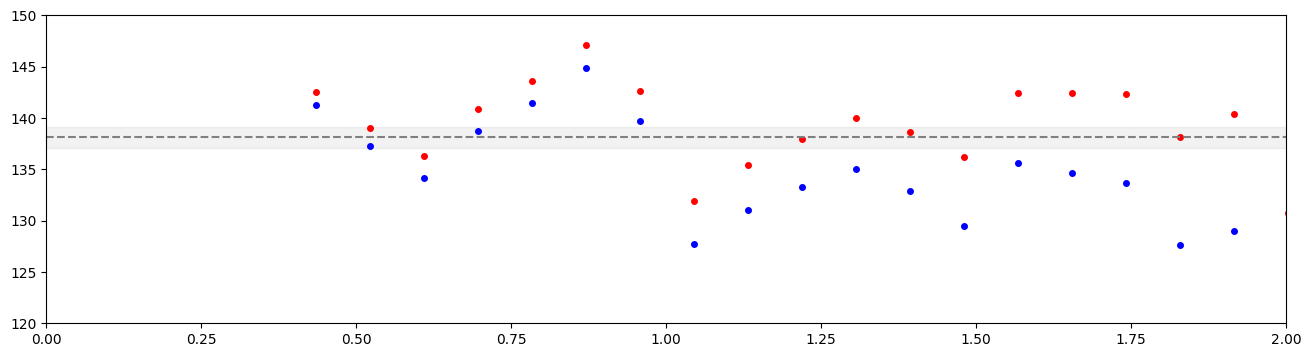

In [41]:
# P
import numpy as np
import h5py, warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import leastsq, curve_fit, fsolve
mpl.rcParams['lines.markersize'] = 4

totalT=96

lat_a=0.0871
hbarc = 1/197.3
lat_aInv=1/(lat_a*hbarc)

def fsolve2(func,x0):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res=fsolve(func, x0)[0]
    return res if res!=x0 else np.NaN
tau=1
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t

fig, axs = plt.subplots(1, 1, figsize=(16,4), squeeze=False, sharex=True)
ax=axs[0,0]
ax.set_ylim([120,150])
ax.set_xlim([0,2])

color='grey'
mean=np.array([138.1]*totalT); err=np.array([1.0]*totalT)
x=np.arange(0,totalT)*lat_a; ymin=mean-err; ymax=mean+err
ax.plot(x,mean,color=color,linestyle='--',marker='')
ax.fill_between(x, ymin, ymax, color=color, alpha=0.1)

def c2pt2meff_log(c2pt):
    meff=np.log(c2pt/np.roll(c2pt,-1))
    return meff

path='/capstor/store/cscs/userlab/lp139/lyan/code/scratch/run/03_NpiScatteringWilson/MILC_a09m130W/run/a0204/Diagram0204_P.h5'
with h5py.File(path) as f:
    srcs=list(f.keys())
    t=np.mean([f[src]['PhiPhi/pi2=0_0_0/a_a'][:,0,0] for src in srcs[:]],axis=0)
    c2pt=t[...,0]
    meff=C2pt2meff(c2pt,totalT)*lat_aInv
    
    ts=np.arange(0,len(t))
    ax.scatter(ts*lat_a,meff,color='r')
    
    meff=c2pt2meff_log(c2pt)*lat_aInv
    ts=np.arange(0,len(t))
    ax.scatter(ts*lat_a,meff,color='b')

alphaGauss=1.0, nGauss_opt=80, rms_opt=0.5033095864383549


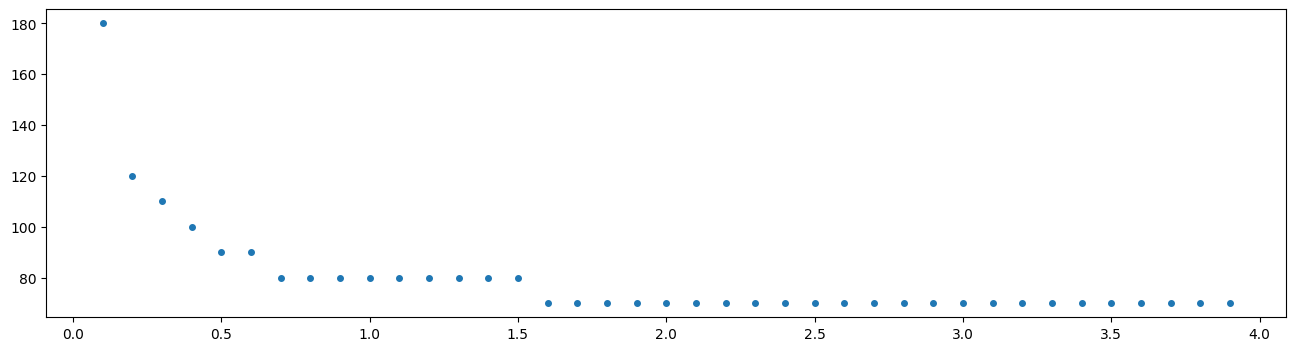

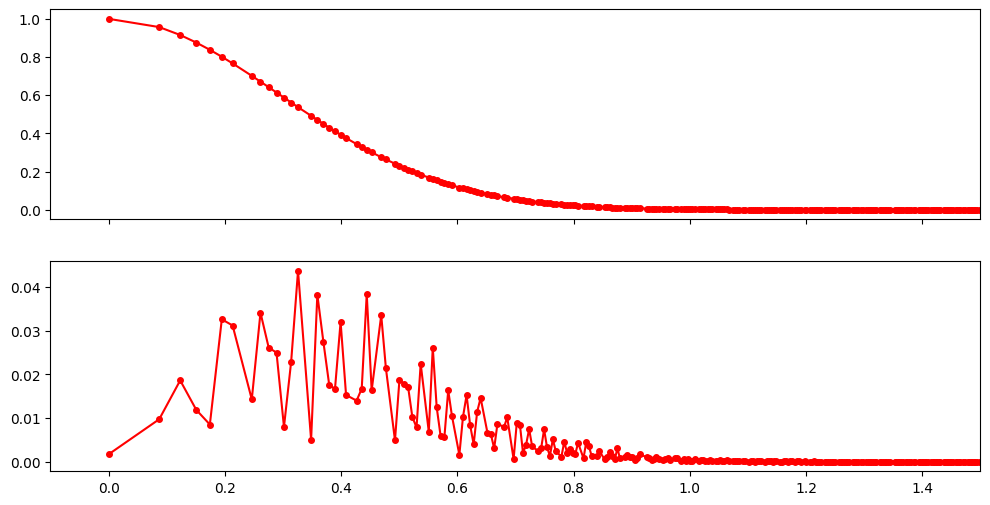

In [1]:
# smearing 

import os
import numpy as np
np.set_printoptions(legacy='1.25')
from math import floor, log10
def un2str(x, xe, precision=2):
    """pretty print nominal value and uncertainty

    x  - nominal value
    xe - uncertainty
    precision - number of significant digits in uncertainty

    returns shortest string representation of `x +- xe` either as
        x.xx(ee)e+xx
    or as
        xxx.xx(ee)"""
    # base 10 exponents
    x_exp = int(floor(log10(np.abs(x))))
    xe_exp = int(floor(log10(xe)))

    # uncertainty
    un_exp = xe_exp-precision+1
    un_int = round(xe*10**(-un_exp))

    # nominal value
    no_exp = un_exp
    no_int = round(x*10**(-no_exp))

    # format - nom(unc)exp
    fieldw = x_exp - no_exp
    fmt = '%%.%df' % fieldw
    result1 = (fmt + '(%.0f)e%d') % (no_int*10**(-fieldw), un_int, x_exp)

    # format - nom(unc)
    fieldw = max(0, -no_exp)
    fmt = '%%.%df' % fieldw
    result2 = (fmt + '(%.0f)') % (no_int*10**no_exp, un_int*10**max(0, un_exp))
    if un_exp<0 and un_int*10**un_exp>=1:
        fmt2= '(%%.%df)' % (-un_exp)
        result2 = (fmt + fmt2) % (no_int*10**no_exp, un_int*10**un_exp)

    # return shortest representation
    if len(result2) <= len(result1):
        return result2
    else:
        return result1

# path='/capstor/store/cscs/userlab/s1174/lyan/code/scratch/run/quark_rms/cB211.072.64/run/a1000/'
# nAPE=50; aAPE=0.5
# a=0.07957; a_err=0.00013
# alphas=[0.2,1.0]

# path='/capstor/store/cscs/userlab/s1174/lyan/code/scratch/run/quark_rms/A15/run/a0050/'
# nAPE=25; aAPE=0.4
# a=0.1163; a_err=0.0004
# alphas=[1.0,3.0]

path='/capstor/store/cscs/userlab/lp139/lyan/code/scratch/run/quark_rms/MILC_a09m130W/run/a0204/'
nAPE=50; aAPE=0.5
a=0.0871; a_err=0.0006
alphas=[1.0]

rms_expected=0.5

def num2str(num):
    res=str(num).replace('.','p')[:3]
    if len(res)==3 and res[-1]=='0':
        res=res[:2]
    return res
def get(aGau,nGau):
    file=f'output_nAPE{nAPE}_aAPE{num2str(aAPE)}_nGau{nGau}_aGau{num2str(aGau)}'
    with open(f'{path}{file}','r') as f:
        t=f.read().splitlines()
        t=[row.split('\t') for row in t]
        t=[[int(e0),int(e1),float(e2)] for e0,e1,e2 in t]
    r2s,counts,phi2s=np.transpose(t)
    return r2s,counts,phi2s

aGaus=[round(ele,1) for ele in np.arange(0.1,4.,0.1)]
nGaus=range(10,200+1,10)
nGaus_opt=[]
rmss_opt=[]
for aGau in aGaus:
    rmss=[]
    for nGau in nGaus:
        r2s,counts,phi2s=get(aGau,nGau)
        rms=np.sqrt(np.sum(r2s*phi2s)/np.sum(phi2s))*a
        rmss.append(rms)
        
        # if aGau==3.0 and nGau==60:
        #     print(aGau,nGau,'| rms=',rms)
            
    drmss=np.abs(np.array(rmss)-rms_expected)
    ind=np.argmin(drmss)
    nGaus_opt.append(nGaus[ind] if drmss[ind]<0.1 else None)
    rmss_opt.append(rmss[ind])

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['lines.markersize'] = 4
fig, axs = plt.subplots(1, 1, figsize=(16,4), squeeze=False, sharex=True, sharey=True)
ax=axs[0,0]
ax.scatter(aGaus,nGaus_opt)
for alpha in alphas:
    ind=aGaus.index(alpha); print(f'alphaGauss={aGaus[ind]}, nGauss_opt={nGaus_opt[ind]}, rms_opt={rmss_opt[ind]}')

colors=['r','g','b','purple']
fig, axs = plt.subplots(2, 1, figsize=(12,6), squeeze=False, sharex=True)
ax=axs[0,0]; ax1=axs[1,0]
for i,alpha in enumerate(alphas):
    ind=aGaus.index(alpha)
    r2s,counts,phi2s=get(aGaus[ind],nGaus_opt[ind])
    x=np.sqrt(r2s)*a; y=phi2s/counts/phi2s[0] 
    ax.plot(x,y,color=colors[i],marker='o')
    x=np.sqrt(r2s)*a; y=phi2s/np.sum(phi2s)
    ax1.plot(x,y,color=colors[i],marker='o')

ax.set_xlim([-0.1,1.5])
None